# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Exploration

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1382]:
import pandas as pd
import numpy as np
import math
import json
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('Set2')

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Cleaning portfolio.json

In [1383]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [1384]:
portfolio.shape

(10, 6)

In [1385]:
portfolio.id.nunique()

10

In [1386]:
# extracting portfolio channels
new_portfolio = portfolio.copy()
new_portfolio['web'] = new_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
new_portfolio['email'] = new_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
new_portfolio['mobile'] = new_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
new_portfolio['social'] = new_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

new_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [1387]:
# extracting portfolio offer types
new_portfolio['bogo'] = new_portfolio['offer_type'].apply(lambda x: 1 if x=='bogo' else 0)
new_portfolio['informational'] = new_portfolio['offer_type'].apply(lambda x: 1 if x=='informational' else 0)
new_portfolio['discount'] = new_portfolio['offer_type'].apply(lambda x: 1 if x=='discount' else 0)

new_portfolio.rename(columns={'id':'offer_id'}, inplace=True)
new_portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1


### Cleaning profile.json

In [1388]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1389]:
profile.shape

(17000, 5)

In [1390]:
# checking null values
profile.notnull().sum()

gender              14825
age                 17000
id                  17000
became_member_on    17000
income              14825
dtype: int64

In [1391]:
# Exploring records with gender null values
profile[profile.gender.isnull()==True].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [1392]:
# counting the total of null values in gender
profile[profile.gender.isnull()==True].age.value_counts()

118    2175
Name: age, dtype: int64

In [1393]:
# removing age 118 since it's related to null entries in gender and income
new_profile = profile.copy()
new_profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
new_profile.dropna(inplace=True)

In [1394]:
# double-checking null values
new_profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [1395]:
# converting 'became_member_on' to date
new_profile['m_date'] = pd.to_datetime(new_profile['became_member_on'], format='%Y%m%d')

# extracting year, month, and day
# new_profile['m_year'] = [dt.year for dt in new_profile['m_date']]
# new_profile['m_month'] = [dt.month for dt in new_profile['m_date']]
# new_profile['m_day'] = [dt.day for dt in new_profile['m_date']]  

#calculating the number of membership days
new_profile['m_days'] = datetime.datetime.today().date() - new_profile['m_date'].dt.date
new_profile['m_days'] = new_profile['m_days'].dt.days

# create a seperate dataframe for gender and then merge it with the original one
df_gender = pd.get_dummies(new_profile['gender'],prefix="gender_")
new_profile = pd.concat([new_profile, df_gender], axis=1)

new_profile.rename(columns={'id':'user_id'}, inplace=True)
new_profile

,gender,age,user_id,became_member_on,income,m_date,m_days,gender__F,gender__M,gender__O
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,1379,1,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,1446,1,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26,1094,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09,1170,0,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017-11-11,1260,0,1,0
...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04,1055,1,0,0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13,1016,0,1,0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26,1549,0,1,0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07,1874,1,0,0


### Cleaning transcript.json

In [1396]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1397]:
transcript.shape

(306534, 4)

In [1398]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [1399]:
# explore one user's events
transcript[transcript['person']=='2eeac8d8feae4a8cad5a6af0499a211d']

,person,event,value,time
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
53182,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168
65844,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168
85293,2eeac8d8feae4a8cad5a6af0499a211d,transaction,{'amount': 2.32},216
110835,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336
130152,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},348
141567,2eeac8d8feae4a8cad5a6af0499a211d,transaction,{'amount': 5.29},378
187136,2eeac8d8feae4a8cad5a6af0499a211d,transaction,{'amount': 7.14},456
187137,2eeac8d8feae4a8cad5a6af0499a211d,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,456
243231,2eeac8d8feae4a8cad5a6af0499a211d,transaction,{'amount': 0.87},570


In [1400]:
# extracting dataframe rows with offer events only
new_transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
new_transcript['offer_id'] = new_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

new_transcript.head()

<ipython-input-1400-8adfa846361a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transcript['offer_id'] = new_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])


,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [1401]:
# checking that transaction events are removed
new_transcript[new_transcript['person']=='2eeac8d8feae4a8cad5a6af0499a211d']

,person,event,value,time,offer_id
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
53182,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168,2298d6c36e964ae4a3e7e9706d1fb8c2
65844,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168,2298d6c36e964ae4a3e7e9706d1fb8c2
110835,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336,fafdcd668e3743c1bb461111dcafc2a4
130152,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},348,fafdcd668e3743c1bb461111dcafc2a4
187137,2eeac8d8feae4a8cad5a6af0499a211d,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,456,fafdcd668e3743c1bb461111dcafc2a4


In [1402]:
# create a seperate dataframe for event and then merge it with the original one
df_event = pd.get_dummies(new_transcript['event'])
new_transcript = pd.concat([new_transcript, df_event], axis=1)

new_transcript.rename(columns={'person':'user_id'}, inplace=True)
new_transcript.head()

,user_id,event,value,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [1403]:
# merge all dataframes together
starbucks_df = new_transcript.merge(new_portfolio,on='offer_id',how='left')
starbucks_df = starbucks_df.merge(new_profile,on='user_id',how='left')
starbucks_df.head()

,user_id,event,value,time,offer_id,offer completed,offer received,offer viewed,reward,channels,...,discount,gender,age,became_member_on,income,m_date,m_days,gender__F,gender__M,gender__O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,"[web, email, mobile]",...,0,F,75.0,20170509.0,100000.0,2017-05-09,1446.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,5,"[web, email]",...,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,1,0,2,"[web, email, mobile]",...,1,M,68.0,20180426.0,70000.0,2018-04-26,1094.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,2,"[web, email, mobile, social]",...,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,10,"[web, email, mobile, social]",...,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


## Data Visualization

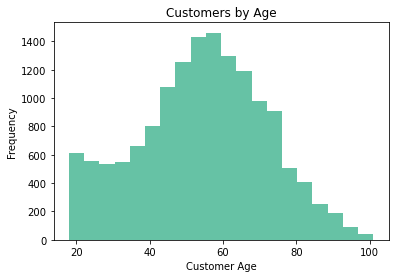

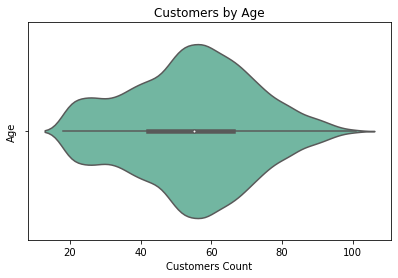

In [1404]:
# distribution of customers by age
age = new_profile['age'].plot(kind='hist', bins=20, title='Customers by Age')
age.set_xlabel("Customer Age")

plt.figure(figsize=(6.5, 4))
sns.violinplot(new_profile['age'], orient='h')
plt.title('Customers by Age')
plt.xlabel('Customers Count')
plt.ylabel('Age');

** Observation:**
Here we notice that the majority of customers are in their late 50's. We can then say that our focus is going to be the elderly category. Following them comes the young category (customers in their 20's). Finally, we have adults in their 30's-40's. 


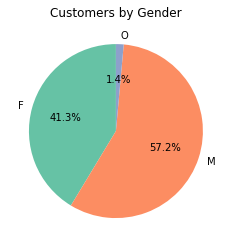

In [1405]:
# distribution of customers by gender
gender = profile.groupby('gender').id.count().plot(kind='pie' ,figsize=(4,4)  , startangle=90, autopct='%1.1f%%' , title= "Customers by Gender");
gender.set_ylabel("");


** Observation:**
Here we see that male profiles are greater than females. 

Text(0.5, 0, 'Membrship Days')

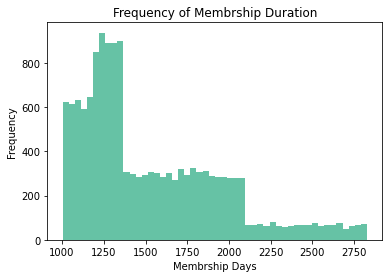

In [1406]:
# distribution of customers by membership days
days = new_profile['m_days'].plot(kind='hist', bins=50, title='Frequency of Membrship Duration')
days.set_xlabel("Membrship Days")

** Observation:**
Here we see an increasing pattern of customers signing up for the Starbucks membership. The frequency of short membership duration is significantly higher. This means we can focus on new customers.

Text(0.5, 0, 'Income')

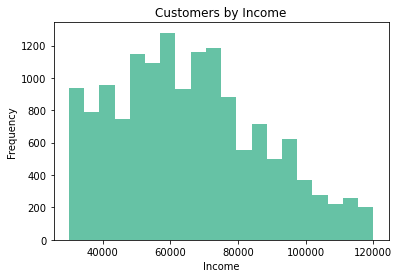

In [1407]:
# distribution of customers by income
income = new_profile['income'].plot(kind='hist', bins=20, title='Customers by Income')
income.set_xlabel("Income")

** Observation:**
Here we observe that the average distribution of customers income is centered around 60,000-80,000. 

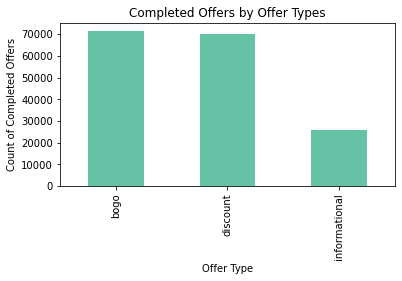

In [1408]:
# Count of completed offers by offer type
offer_com = starbucks_df.groupby('offer_type')['offer completed'].count().plot(kind='bar' ,figsize=(6,3)  , title= "Completed Offers by Offer Types");
offer_com.set_xlabel("Offer Type")
offer_com.set_ylabel("Count of Completed Offers");

**Observation:** 
Here we can see that most popular offers are Bogo (Buy one get one) then Discount. Informational offers are not that popular.

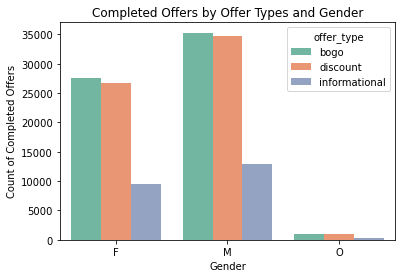

In [1409]:
# completed offers by offer types and gender
plt.figure(figsize=(6, 4))
sns.countplot(x="gender", hue="offer_type", data=starbucks_df)
plt.title( "Completed Offers by Offer Types and Gender");
plt.xlabel("Gender")
plt.ylabel("Count of Completed Offers");

**Observation:** 
We noticed earlier that male profiles are greater than females. So it makes sense here that males completed more offers. For both males and females, we clearly see that BOGOs are more popular followed closely by discount offers.

In [1410]:
# dropping unnecessary columns
starbucks_df.drop(['offer_type','became_member_on','gender','channels','value','event','m_date'], axis=1, inplace=True)

## Data Preprocessing

In [1411]:
# prepare the offer viewed dataframe
starbucks_offer_viewed= starbucks_df[starbucks_df['offer viewed']==1]
starbucks_offer_viewed.drop(['offer completed'], axis = 1, inplace=True)

starbucks_offer_viewed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57725 entries, 12650 to 167578
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         57725 non-null  object 
 1   time            57725 non-null  int64  
 2   offer_id        57725 non-null  object 
 3   offer received  57725 non-null  uint8  
 4   offer viewed    57725 non-null  uint8  
 5   reward          57725 non-null  int64  
 6   difficulty      57725 non-null  int64  
 7   duration        57725 non-null  int64  
 8   web             57725 non-null  int64  
 9   email           57725 non-null  int64  
 10  mobile          57725 non-null  int64  
 11  social          57725 non-null  int64  
 12  bogo            57725 non-null  int64  
 13  informational   57725 non-null  int64  
 14  discount        57725 non-null  int64  
 15  age             49860 non-null  float64
 16  income          49860 non-null  float64
 17  m_days          49860 non-

In [1412]:
# prepare the offer completed dataframe
starbucks_offer_completed= starbucks_df[starbucks_df['offer completed']==1][['offer_id','user_id', 'offer completed']]

starbucks_offer_completed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 12656 to 167580
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   offer_id         33579 non-null  object
 1   user_id          33579 non-null  object
 2   offer completed  33579 non-null  uint8 
dtypes: object(2), uint8(1)
memory usage: 819.8+ KB


In [1413]:
# merge the two dataframes
starbucks_modeling = starbucks_offer_viewed.merge(starbucks_offer_completed, on=['offer_id','user_id'], how='inner')

starbucks_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37952 entries, 0 to 37951
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          37952 non-null  object 
 1   time             37952 non-null  int64  
 2   offer_id         37952 non-null  object 
 3   offer received   37952 non-null  uint8  
 4   offer viewed     37952 non-null  uint8  
 5   reward           37952 non-null  int64  
 6   difficulty       37952 non-null  int64  
 7   duration         37952 non-null  int64  
 8   web              37952 non-null  int64  
 9   email            37952 non-null  int64  
 10  mobile           37952 non-null  int64  
 11  social           37952 non-null  int64  
 12  bogo             37952 non-null  int64  
 13  informational    37952 non-null  int64  
 14  discount         37952 non-null  int64  
 15  age              36560 non-null  float64
 16  income           36560 non-null  float64
 17  m_days      

In [1414]:
# drop rows with null values 
starbucks_modeling.dropna(inplace=True)
starbucks_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36560 entries, 0 to 37951
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          36560 non-null  object 
 1   time             36560 non-null  int64  
 2   offer_id         36560 non-null  object 
 3   offer received   36560 non-null  uint8  
 4   offer viewed     36560 non-null  uint8  
 5   reward           36560 non-null  int64  
 6   difficulty       36560 non-null  int64  
 7   duration         36560 non-null  int64  
 8   web              36560 non-null  int64  
 9   email            36560 non-null  int64  
 10  mobile           36560 non-null  int64  
 11  social           36560 non-null  int64  
 12  bogo             36560 non-null  int64  
 13  informational    36560 non-null  int64  
 14  discount         36560 non-null  int64  
 15  age              36560 non-null  float64
 16  income           36560 non-null  float64
 17  m_days      

In [1415]:
# drop user_id and offer_id because they are no longer needed
starbucks_modeling.drop(['user_id','offer_id'], axis = 1, inplace=True)

In [1416]:
# split dataset into training and testing sets
features_df = starbucks_modeling.drop(['offer completed'], axis = 1)
target_df = starbucks_modeling['offer completed']
x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, random_state=42)

## Implementation:

In [1417]:
# test mutiple classifiers using the train and test datasets to asses the classifier accuracy

# select classifiers
classifiers = {'Decision Tree' : DecisionTreeClassifier(), 'Random Forest' : RandomForestClassifier(), 'AdaBoost' : AdaBoostClassifier()}

for name, classifier in classifiers.items():
    
    # fit classifier
    fit_classifier = classifier.fit(x_train, y_train)
    
    # prediction with training dataset
    train_prediction = fit_classifier.predict(x_train)
    
    # prediction with testing dataset
    test_prediction = fit_classifier.predict(x_test)
    
    # accuracy on training dataset
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # accuracy on testing dataset
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    results = {'Classifier': name, 'Training Accuracy': train_accuracy, 'Testing Accuracy' :test_accuracy}
    print(results)

{'Classifier': 'Decision Tree', 'Training Accuracy': 1.0, 'Testing Accuracy': 1.0}
{'Classifier': 'Random Forest', 'Training Accuracy': 1.0, 'Testing Accuracy': 1.0}
{'Classifier': 'AdaBoost', 'Training Accuracy': 1.0, 'Testing Accuracy': 1.0}


**Observation:** It seems like all three classifiers are the same. So, I'll go with any of them.

## Metrics:
We need to evaluate the performance of our model and I choose Accuracy to do so. This will allows us to calculate the ratio of correctly classified predictions to the overall number of model predictions. Therefore, accuracy is the metric of choice.


In [1418]:
# use grid search to find the best parameters
parameters = {
 'n_estimators': [50, 100,150,200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
    'algorithm':['SAMME', 'SAMME.R']
 }
    
model = GridSearchCV(classifiers['AdaBoost'], param_grid = parameters, n_jobs = -1, scoring = 'accuracy')
model.fit(x_train,y_train)
print("The best parameters are: ", model.best_params_)


The best parameters are:  {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 50}


## Refinement:

In [1419]:
# enhanced classifier
e_classifier = AdaBoostClassifier(algorithm='SAMME', learning_rate= 0.01, n_estimators= 50)
    
# fit classifier
fit_e_classifier = e_classifier.fit(x_train, y_train)
    
# prediction with training dataset
e_train_prediction = fit_e_classifier.predict(x_train)
    
# prediction with testing dataset
e_test_prediction = fit_e_classifier.predict(x_test)
    
# accuracy on training dataset
e_train_accuracy = accuracy_score(y_train, e_train_prediction)
    
# accuracy on testing dataset
e_test_accuracy = accuracy_score(y_test, e_test_prediction)
    
results = {'Classifier': 'AdaBoostClassifier', 'Training Accuracy': e_train_accuracy, 'Testing Accuracy' :e_test_accuracy}
print(results)

{'Classifier': 'AdaBoostClassifier', 'Training Accuracy': 1.0, 'Testing Accuracy': 1.0}


## Conclusion
Based on our data analysis, we suggest that Starbucks should focus on the following groups of customers:
- **Elderly Customers** since they resembles the vast majority of users in profile dataset.
- **New Customers** since the frequency of short membership durations is significantly higher.
- **Male Customers** since their profiles total is slightly higher than females. This does not mean that female customers are not significant.
- **BOGO and Discount** offers are the way to go. Informational offers are not that significant.

### Reflections
To predict whether or not a user will respond to an offer, I used a technique of merging the offers viewed and offers completed together, and then trained a number of classifiers and tested them to decide on the best classifier to use for predictions.

### Improvements
It was a bit starnge to get the same accuracy for all classifiers. Maybe there is a room for improvements there. Also, customers information were limited leading to very few features for the model.